<a href="https://colab.research.google.com/github/anapitalai/gee/blob/main/carto_ee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cartopy scipy matplotlib python-dotenv osmnx


In [22]:
%matplotlib inline
%pylab inline
import numpy as np
import pandas as pd
import ee
import os
import geemap
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from dotenv import load_dotenv
import osmnx as ox
import geopandas as gpd

# import the cartoee functionality from geemap
from geemap import cartoee
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.geoaxes import GeoAxes, GeoAxesSubplot




Populating the interactive namespace from numpy and matplotlib


In [23]:
dotenv_path = '/content/drive/MyDrive/env/.env'
load_dotenv(dotenv_path=dotenv_path)

# Access the environment variables
project_name = os.getenv("project_name")

ee.Authenticate()
ee.Initialize(project=project_name)

In [4]:
##global variable
roi_in_png = ee.Geometry.Point([146.997,-6.6673])

In [38]:
Map = geemap.Map()

image = (
    ee.ImageCollection("MODIS/MCD43A4_006_NDVI")
    .filter(ee.Filter.date("2022-04-01", "2024-01-01"))  ##("2018-04-01", "2018-05-01")
    .select("NDVI")
    .first()
)

vis_params = {
    "min": 0.0,
    "max": 1.0,
    "palette": [
        "FFFFFF",
        "CE7E45",
        "DF923D",
        "F1B555",
        "FCD163",
        "99B718",
        "74A901",
        "66A000",
        "529400",
        "3E8601",
        "207401",
        "056201",
        "004C00",
        "023B01",
        "012E01",
        "011D01",
        "011301",
    ],
}
Map.set_center(146.677, -6.677, 8)
Map.addLayer(image, vis_params, "MODIS NDVI")
countries = ee.FeatureCollection("users/giswqs/public/countries")
style = {"color": "00000088", "width": 1, "fillColor": "00000000"}
Map.addLayer(countries.style(**style), {}, "Countries")
ndvi = image.visualize(**vis_params)
blend = ndvi.blend(countries.style(**style))


Map.addLayer(blend, {}, "Blend")
# Save the map as an HTML file.
Map.save('vegetation.html')
Map


Map(center=[-6.677, 146.677], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

In [ ]:
# specify region to focus on
bbox = [180, -88, -180, 88]
zoom_region = [140.0, -12.0, 156.0, -1.0]
#zoom_region = [140.0, -12.0, 160.0, 0]


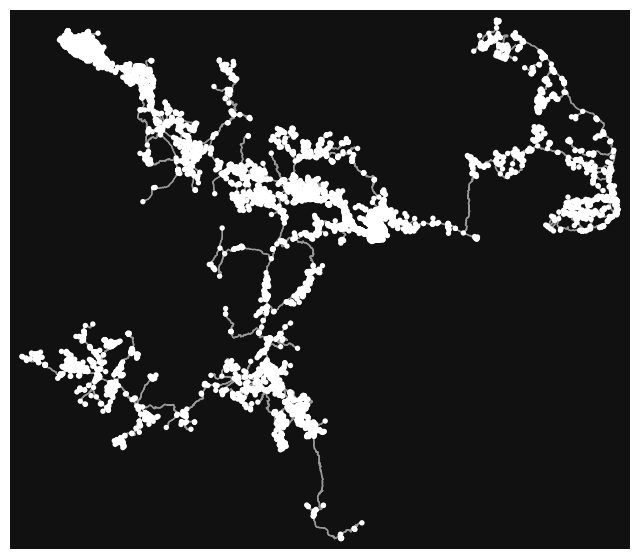

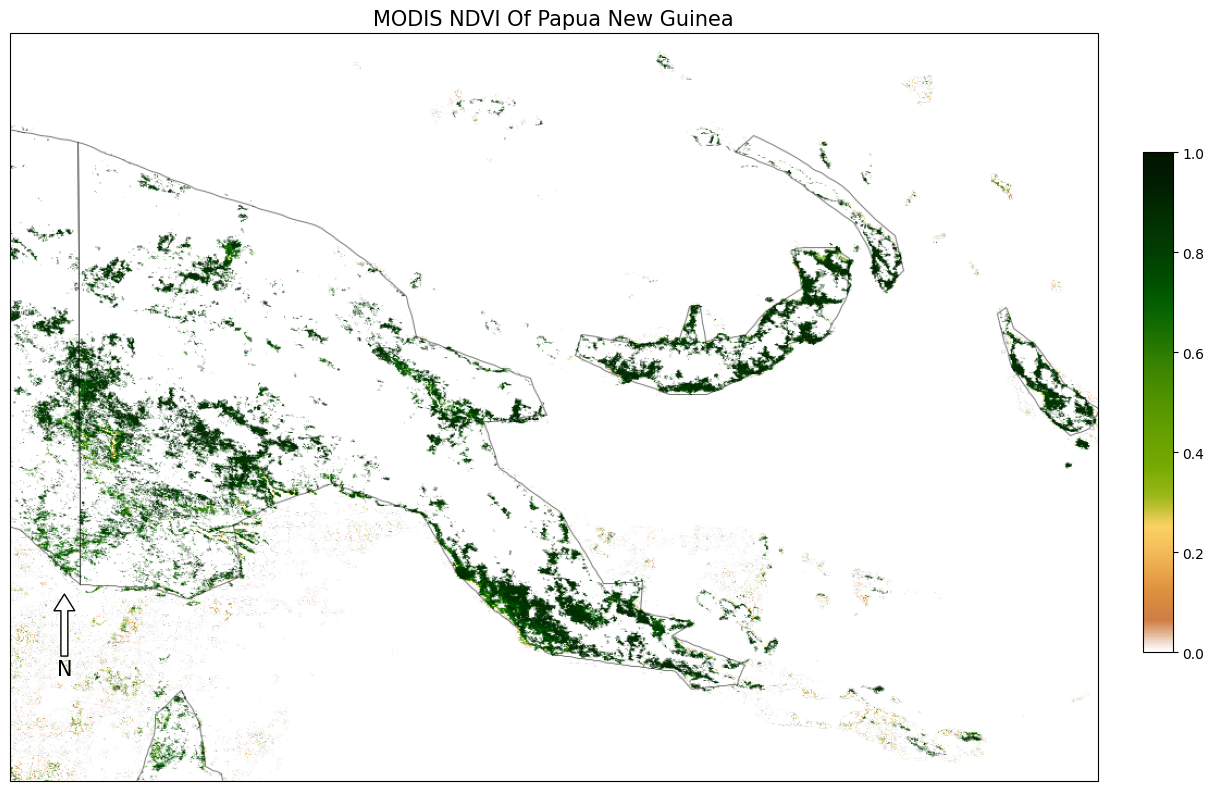

In [40]:
morobe=ox.plot_graph(ox.graph_from_place('Morobe, Papua New Guinea'))

fig = plt.figure(figsize=(15, 10))
ax = cartoee.get_map(blend, region=zoom_region)
#ax = cartoee.get_map(blend, region=bbox, proj=projection
cb = cartoee.add_colorbar(ax, vis_params=vis_params, loc="right")

ax.set_title(label="MODIS NDVI Of Papua New Guinea", fontsize=15)

cartoee.add_north_arrow(
    ax, text="N", xy=(0.05, 0.25), text_color="black", arrow_color="white", fontsize=15
)
# ax.coastlines()
plt.show()

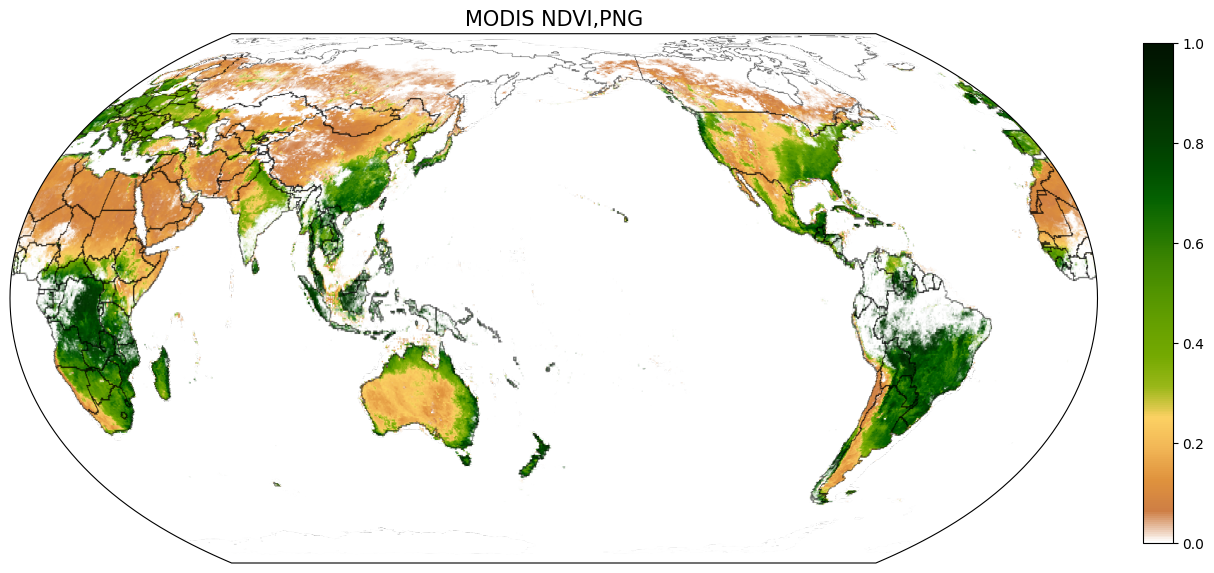

In [41]:
fig = plt.figure(figsize=(15, 10))

projection = ccrs.EqualEarth(central_longitude=-180)

# plot the result with cartoee using a PlateCarre projection (default)
ax = cartoee.get_map(blend, region=bbox, proj=projection,zoom_level=21)
cb = cartoee.add_colorbar(ax, vis_params=vis_params, loc="right")

ax.set_title(label="MODIS NDVI,PNG", fontsize=15)

# ax.coastlines()
plt.show()

In [42]:
dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(
    '2025-01-01', '2025-02-01'
).filterMetadata('CLOUD_COVER', 'less_than', 10)

#image=dataset.getInfo()
#dataset=dataset.median().reproject(crs="EPSG:4326", scale=30)
# Get the ID of the single image.
#image_id = single_image.get('system:id').getInfo()

#print(image_id)


# Applies scaling factors.
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )

dataset = dataset.map(apply_scale_factors)

zoom_region = [140.0, -12.0, 156.0, -1.0]
composite = dataset.median().reproject(crs='EPSG:3857', scale=30)

vis = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0.0,
    'max': 0.3,
}

countries = ee.FeatureCollection("users/giswqs/public/countries")
style = {"color": "00000088", "width": 1, "fillColor": "00000000"}

# ndvi = image.visualize(**vis_params)
# blend = ndvi.blend(countries.style(**style))
# Map.addLayer(blend, {}, "Blend")


Map = geemap.Map()
Map.addLayer(countries.style(**style), {}, "Countries")
Map.set_center(146.677, -6.677, 8)
#Map.addLayer(countries, style,'COUNTRY')

Map.addLayer(dataset, vis,'True Color (432)')
Map


Map(center=[-6.677, 146.677], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

Help on method set_extent in module cartopy.mpl.geoaxes:

set_extent(extents, crs=None) method of cartopy.mpl.geoaxes.GeoAxes instance
    Set the extent (x0, x1, y0, y1) of the map in the given
    coordinate system.
    
    If no crs is given, the extents' coordinate system will be assumed
    to be the Geodetic version of this axes' projection.
    
    Parameters
    ----------
    extents
        Tuple of floats representing the required extent (x0, x1, y0, y1).



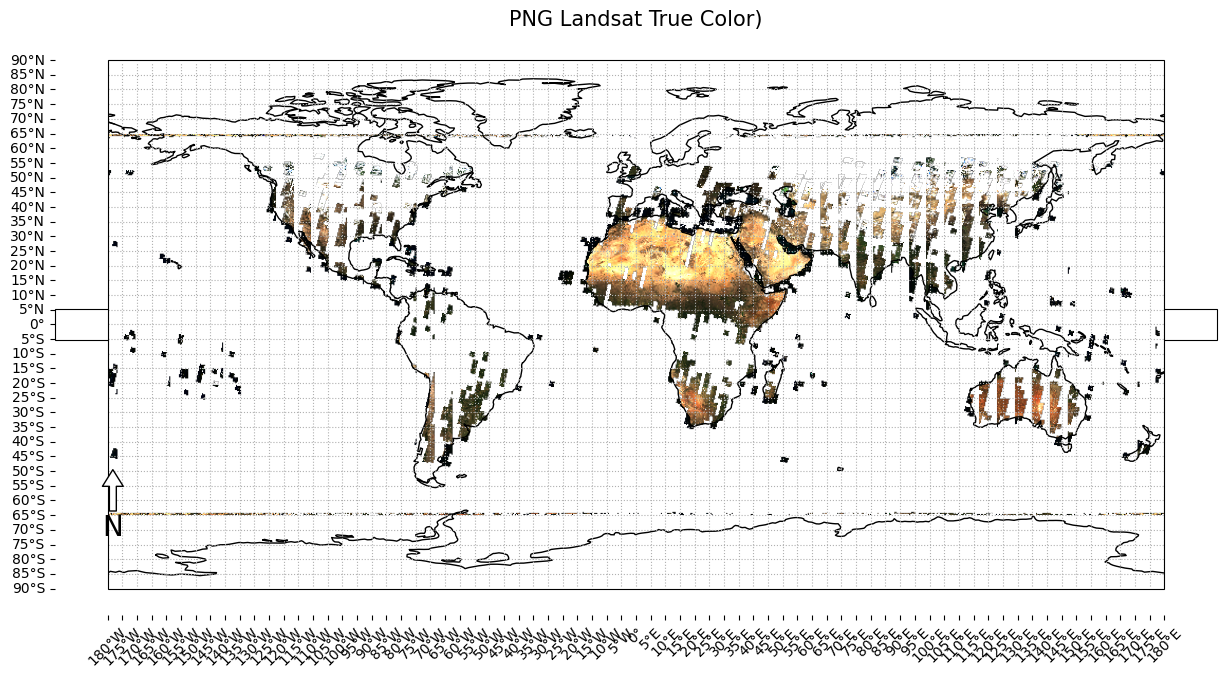

In [43]:

#zoom_region=[E,S,W,N]
#zoom_region = [140.0, -12.0, 156.0, -1.0]
#zoom_region = [180, -60, -180, 85]
#zoom_region = [180, -60, -180, 85]

#projection = ccrs.Mollweide(central_longitude=-180)
projection = ccrs.PlateCarree()
#projection=ccrs.Mercator()
#projection=ccrs.Geodetic()
#crs="EPSG:32620"
#projection = ccrs.EqualEarth(central_longitude=-180)


fig = plt.figure(figsize=(15, 10))


extent = [140.842, -11.636, 156.019, -1.346]
ax = plt.subplot(projection=projection)
ax.set_extent(extent)
help(ax.set_extent)

# use cartoee to get a map
ax = cartoee.get_map(dataset, vis_params=vis)
#help(cartoee.get_map)

# pad the view for some visual appeal
cartoee.pad_view(ax)
##add extents

cartoee.add_gridlines(ax, interval=5, xtick_rotation=45, linestyle=":")

# add the coastline
ax.coastlines(color="black")
# add north arrow
cartoee.add_north_arrow(
    ax, text="N", xy=(0.05, 0.25), text_color="black", arrow_color="white", fontsize=20
)

# add scale bar
cartoee.add_scale_bar_lite(
    ax, length=10, xy=(0.1, 0.05), fontsize=20, color="black", unit="km"
)

ax.set_title(label="PNG Landsat True Color)", fontsize=15)

# Save the plot by calling plt.savefig() BEFORE plt.show()
# plt.savefig("rgb.pdf")
# plt.savefig("rgb.jpg", dpi=300)
plt.show()



Try Sentinel Data 2 instead to make a map. Tried landsat8 above the images
dont align.

In [44]:
roi_in_png = ee.Geometry.Point([146.997,-6.6673])

def pansharpen(image):
    # Select the panchromatic band (B8) and the RGB bands (B4, B3, B2).
    pan_band = image.select('B8')
    rgb_bands = image.select(['B4', 'B3', 'B2'])

    # Apply a high-pass filter to the panchromatic band.
    pan_sharpened = rgb_bands.add(pan_band.subtract(pan_band.focal_mean(15)).multiply(0.5))

    return pan_sharpened


Map = geemap.Map()
map=geemap.Map(center=[-6.677,146.677],zoom=20)
collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
.filterDate('2024-01-01', '2025-01-31') \
.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 15)).filterBounds(roi_in_png)

image = collection.first()
# Get the ID of the single image.
image_id = image.get('system:id').getInfo()
print(image_id)

# Apply the pansharpening function to the image.
pansharpened_image = pansharpen(image)

vis = {
'min': 0.0,
'max': 3000,
'bands': ['B4', 'B3', 'B2'],
}

countries = ee.FeatureCollection("users/giswqs/public/countries")
Map.setCenter(146.997,-6.6673, 12)
Map.addLayer(image, vis, 'Sentinel-2')
Map.addLayer(pansharpened_image, vis, 'Pansharpened')
Map
Map

COPERNICUS/S2_SR_HARMONIZED/20240326T003709_20240326T003746_T55MDN


Map(center=[-6.6673, 146.997], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [ ]:
#save single image to google drive

In [45]:
# Define export parameters.
export_params = {
    'image': image.clip(roi_in_png),
    'description': 'Landsat8_Single_Image_PNG',
    'scale': 10,
    'region': roi_in_png,
    'fileFormat': 'GeoTIFF',
    'folder': 'EarthEngineExports'
}

In [ ]:
# Export the image to Google Drive.
task = ee.batch.Export.image.toDrive(**export_params)
task.start()
import time

while task.status()['state'] in ['READY', 'RUNNING']:
    print('Task is still running...')
    time.sleep(10)

print('Task completed:', task.status())


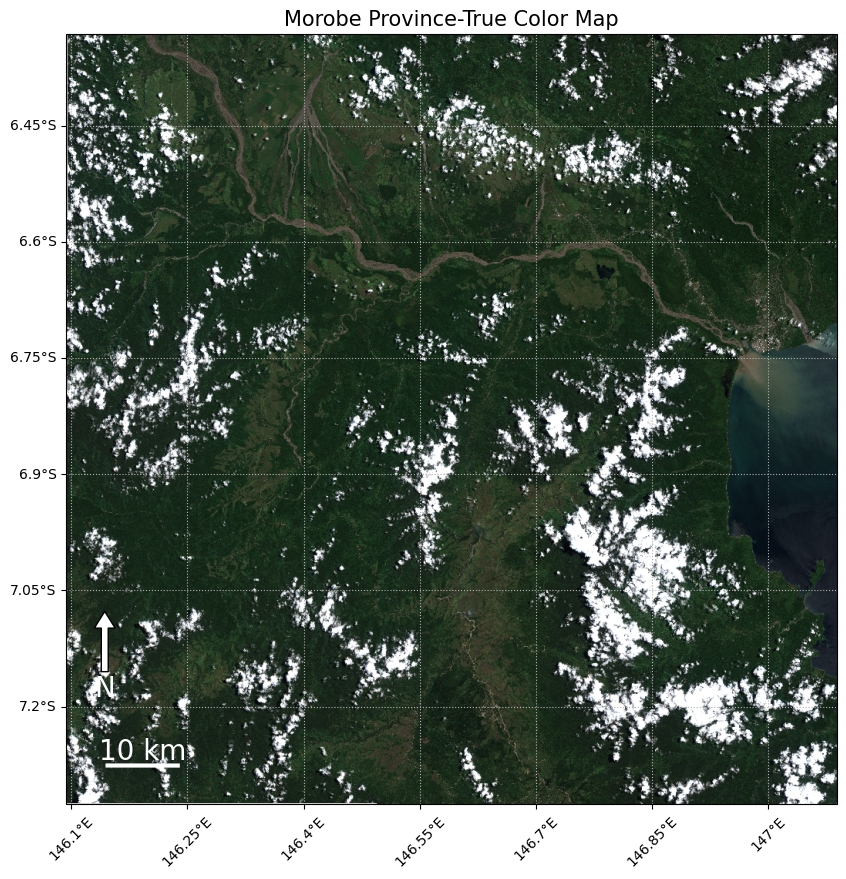

In [37]:

##plot a single image

#zoom_region=[E,S,W,N]
region = [146.9, -6.7, 147.1, -6.6]
# get a landsat image to visualize
image = ee.Image("COPERNICUS/S2_SR_HARMONIZED/20240326T003709_20240326T003746_T55MDN")
image = image.reproject(crs='EPSG:4326', scale=15)
# define the visualization parameters to view
vis = {"bands": ["B4", "B3", "B2"], "min": 0, "max": 5000, "gamma": 1.3}



projection=ccrs.PlateCarree()


fig = plt.figure(figsize=(15, 10))#15,10


extent = [140.842, -11.636, 156.019, -1.346]
#ax = plt.subplot(projection=projection)
#ax.set_extent(region)

# use cartoee to get a map
ax = cartoee.get_map(image, vis_params=vis,zoom_level=20)##remove region=zoom_region

# pad the view for some visual appeal
#cartoee.pad_view(ax)
##add extents

cartoee.add_gridlines(ax, interval=0.15, xtick_rotation=45, linestyle=":")

# add the coastline
#ax.coastlines(color="black")
# add north arrow
cartoee.add_north_arrow(
    ax, text="N", xy=(0.05, 0.25), text_color="white", arrow_color="white", fontsize=20
)

# add scale bar
cartoee.add_scale_bar_lite(
    ax, length=10, xy=(0.1, 0.05), fontsize=20, color="white", unit="km"
)

ax.set_title(label="Morobe Province-True Color Map", fontsize=15)

# Save the plot by calling plt.savefig() BEFORE plt.show()
# plt.savefig("rgb.pdf")
plt.savefig("rgb.jpg", dpi=300)
plt.show()

